# Stupid Tensorflow Tricks, II
Solving an old physics problem with Tensorflow!
_part one [here](https://towardsdatascience.com/stupid-tensorflow-tricks-3a837194b7a0)_ 

## Brachistocrone problem
What's the fastest way down a ramp? Let's solve for the height of the green dots that minimize the time.

![](figures/plane.png)

In [2]:
import tensorflow as tf
import numpy as np
print(tf.__version__)

# This lets us see computations as soon as we run them!
tf.enable_eager_execution()

1.14.0


In [3]:
# Setup the "ramp"
N = 20
width = 3
y = tf.Variable(np.linspace(0.99, 0.01, N,), dtype=tf.float32)
x = tf.linspace(0.0, 1.0, N+2) * width
print(y)

<tf.Variable 'Variable:0' shape=(20,) dtype=float32, numpy=
array([0.99      , 0.9384211 , 0.88684213, 0.83526313, 0.7836842 ,
       0.73210526, 0.6805263 , 0.6289474 , 0.57736844, 0.5257895 ,
       0.47421053, 0.4226316 , 0.37105262, 0.31947368, 0.26789474,
       0.21631579, 0.16473684, 0.1131579 , 0.06157895, 0.01      ],
      dtype=float32)>


### Conservation of Energy
$$U=K$$
$$mgh = \frac{1}{2}mv^2$$
$$v = \sqrt{2gh}$$

In [4]:
g = tf.constant(9.8)
v = tf.sqrt(2 * g * (1 - y));
print(v)

tf.Tensor(
[0.44271865 1.0986115  1.4892596  1.7968981  2.059075   2.2914486
 2.5023358  2.6967816  2.8781207  3.0486925  3.2102141  3.3639889
 3.5110352  3.652166   3.788042   3.9192104  4.0461287  4.169185
 4.2887125  4.4049973 ], shape=(20,), dtype=float32)


# Time to roll down 
can compute for each little segment...
$$ z(t) = z_0 + v_0 t + \frac{1}{2}a_z t^2 = z_0 + v_0 t + \frac{g \sin(\theta) t^2}{2} $$


$$ t = \frac{-v_0 \pm \sqrt{v_0^2 - 2 g \sin(\theta)z_0}} {g \sin(\theta)} $$

Ugh. We have to keep track of the root: the first root if going up the ramp, the second root if we are moving up the ramp.

... that's stupid and too much work. 

## Lazy physics ...
Over a short enough time span we can ignore gravity, as long as we fix the velocity each segment.

$$ z(t) = z_0 + v_0 t $$
$$ t = z_0 / v_0  $$

The change along the ramp:

![](figures/plane_crop.png)

$$ t = \frac{\sqrt{\Delta x^2 + \Delta y^2}}{v_0}  $$

In [5]:
dx = x[1] - x[0]
dy = y[:-1] - y[1:]
dz = tf.sqrt(dx ** 2 + dy ** 2)
print(dz)

tf.Tensor(
[0.15188335 0.15188335 0.15188336 0.15188335 0.15188335 0.15188335
 0.15188335 0.15188335 0.15188335 0.15188336 0.15188335 0.15188336
 0.15188335 0.15188335 0.15188335 0.15188335 0.15188335 0.15188335
 0.15188335], shape=(19,), dtype=float32)


Let's clean it up, and encapsulate it all in a function.

In [6]:
def compute_ramp(y):
    g = tf.constant(9.8)
    
    # Fix the endpoints
    y = tf.concat([[1.0], y, [0.0]], axis=0)
    
    # All the widths are the same
    dx = x[1] - x[0]
    dy = y[:-1] - y[1:]   
    dz = tf.sqrt(dx ** 2 + dy ** 2)

    # Convervation of energy
    v = tf.sqrt(2 * g * (y[0] - y))
    
    # The average of the starting and ending velocity at each segment
    avg_v = (v[1:] + v[:-1]) / 2

    total_time = tf.reduce_sum(dz / avg_v)
    return total_time

In [7]:
# For a 3x1 ramp, this should be ~ 1.34s
print(compute_ramp(y).numpy())

1.8699454


In [8]:
# Oof. Let's try it with more points!
N = 2000
width = 3
y = tf.Variable(np.linspace(0.90, 0,N,), dtype=tf.float32)
x = tf.linspace(0.0, 1.0, N+2) * width
print(compute_ramp(y).numpy())

1.2172186


In [11]:
# Develop our training step
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

def train_step(y):
    with tf.GradientTape() as tape:
        time = compute_ramp(y)

    variables = [y]
    grads = tape.gradient(time, variables)
    optimizer.apply_gradients(zip(grads, variables))

    return time.numpy()

In [12]:
%%capture
import pylab as plt
import seaborn as sns
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(7,4))
plt.rcParams['figure.dpi'] = 125

In [13]:
N = 500
width = 3
n_steps = 5000

y = tf.Variable(np.random.uniform(-1,0.5,size=(N,)), dtype=tf.float32)
x = tf.linspace(0.0, 1.0, N+2) * width

for i in range(n_steps):
    t = train_step(y)

    if i % 100 == 0 and i > 0:
        print(f"{i} {t:0.16f}")
        yx = np.hstack([[1], y.numpy(), [0]])
        ax.plot(x.numpy(), yx, color='b',alpha=i/n_steps)

W0914 16:20:26.362680 140415724224640 deprecation.py:323] From /home/travis/.pyenv/versions/3.7.0/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100 2.0523071289062500
200 1.1331435441970825
300 1.1005241870880127
400 1.0882843732833862
500 1.0801250934600830
600 1.0740256309509277
700 1.0691733360290527
800 1.0648086071014404
900 1.0609890222549438
1000 1.0575046539306641
1100 1.0536210536956787
1200 1.0505198240280151
1300 1.0474429130554199
1400 1.0446676015853882
1500 1.0417466163635254
1600 1.0389765501022339
1700 1.0367203950881958
1800 1.0346320867538452
1900 1.0379409790039062
2000 1.0322176218032837
2100 1.0301378965377808
2200 1.0291011333465576
2300 1.0288676023483276
2400 1.0315173864364624
2500 1.0274599790573120
2600 1.0257347822189331
2700 1.0300009250640869
2800 1.0298285484313965
2900 1.0246465206146240
3000 1.0271040201187134
3100 1.0240072011947632
3200 1.0258941650390625
3300 1.0231714248657227
3400 1.0256932973861694
3500 1.0229271650314331
3600 1.0240100622177124
3700 1.0294830799102783
3800 1.0245485305786133
3900 1.0244060754776001
4000 1.0228631496429443
4100 1.0245047807693481
4200 1.0228533744812012
4

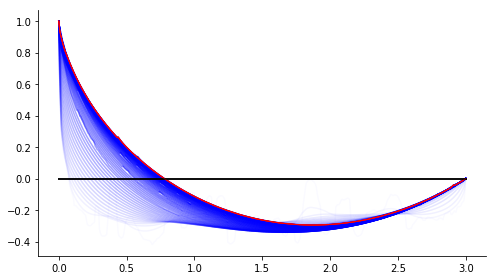

In [16]:
ax.plot(x.numpy(), yx,'r',lw=1)
ax.plot(x.numpy(), 0*x.numpy(),'k',lw=2,alpha=0.6)
sns.despine(ax=ax)
fig.tight_layout()
fig.savefig("figures/final_solution.png")
fig

## Wikipedia solution to the [Brachistochrone](https://en.wikipedia.org/wiki/Brachistochrone_curve)
![](figures/Brachistochrone.gif)
we did pretty well!